# sPOD-NN for 2D non-linear wildland fire data

In [2]:
import sys
sys.path.append('../sPOD/lib/')
sys.path.append('../DL-ROM/LIB/')

In [3]:
from wildfire2DNonLinear_sup import wildfire2DNonLinear_sup
import numpy as np

## Data generation / sPOD of the data

In [4]:
variable = 0  # 0 for temperature and 1 for supply mass fraction
test_val = 558.49

if variable == 0:
    name = "T"
else:
    name = "S"

In [5]:
import os

q = np.load(os.path.abspath(".") + '/wildfire_data/2DNonLinear/' + 'SnapShotMatrix' + str(test_val) + '.npy')
shifts_test = np.load(os.path.abspath(".") + '/wildfire_data/2DNonLinear/' + 'Shifts' + str(test_val) + '.npy')

df = wildfire2DNonLinear_sup(q, shifts_test, param_test_val=test_val, var=variable)

In [6]:
# ############################# Run shifted POD on the data ########################## (only once)
# impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/"
# import os
# import pickle
# os.makedirs(impath, exist_ok=True)

# U_list, TA_list_training, TA_list_interp, spod_modes = df.run_sPOD(spod_iter=9)

# with open(impath + 'U_list.data', 'wb') as filehandle:
#     pickle.dump(U_list, filehandle)
# with open(impath + 'TA_list_training.data', 'wb') as filehandle:
#     pickle.dump(TA_list_training, filehandle)
# with open(impath + 'TA_list_interp.data', 'wb') as filehandle:
#     pickle.dump(TA_list_interp, filehandle)
# with open(impath + 'spod_modes.data', 'wb') as filehandle:
#     pickle.dump(spod_modes, filehandle)
# with open(impath + 'Q_polar_train.data', 'wb') as filehandle:
#     pickle.dump(df.q_polar_train, filehandle)

## Assemble the training data for prediction

In [7]:
impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/"
import os
import pickle

with open(impath + 'U_list.data', 'rb') as filehandle:
    U_list = pickle.load(filehandle) 
with open(impath + 'TA_list_training.data', 'rb') as filehandle:
    TA_list_training = pickle.load(filehandle)  
with open(impath + 'TA_list_interp.data', 'rb') as filehandle:
    TA_list_interp = pickle.load(filehandle) 
with open(impath + 'spod_modes.data', 'rb') as filehandle:
    spod_modes = pickle.load(filehandle) 
with open(impath + 'Q_polar_train.data', 'rb') as filehandle:
    Q_polar_train = pickle.load(filehandle)  

In [8]:
from sklearn.utils.extmath import randomized_svd

TA_TRAIN = np.concatenate(TA_list_training, axis=0)
SHIFTS_TRAIN = df.shift_TA_train
PARAMS_TRAIN = df.params_train

num_shift_modes = int(SHIFTS_TRAIN.shape[0])

u, s, vt = randomized_svd(np.concatenate(df.q_train, axis=1), n_components=sum(spod_modes) + num_shift_modes)

U_POD_TRAIN = u
TA_POD_TRAIN = np.diag(s) @ vt

/opt/homebrew/Caskroom/miniforge/base/envs/PyTorch/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


## ---------------------------------------------------

In [9]:
# ##################################### Only for DoF study #######################################
# # No need to be performed again 
# # The results are shown in the paper
# from Helper import *
# from wildfire2D_sup import polar_to_cartesian, cartesian_to_polar

# frame_wise_sPOD = [1, 1]
# Nmf = spod_modes
# time_amplitudes_1 = TA_TRAIN[:Nmf[0], :]
# time_amplitudes_2 = TA_TRAIN[Nmf[0]:, :]
# frame_amplitudes_list_training = [
#     time_amplitudes_1[:frame_wise_sPOD[0], :],
#     time_amplitudes_2[:frame_wise_sPOD[1], :]
# ]

# TA_TRAIN = np.concatenate(frame_amplitudes_list_training, axis=0)
# U_list = [
#     U_list[0][:, :frame_wise_sPOD[0]], 
#     U_list[1][:, :frame_wise_sPOD[1]]
# ]
# spod_modes = frame_wise_sPOD

# frame_amplitudes_list_interp = []
# for frame in range(2):
#     Nmodes = spod_modes[frame]
#     VT = frame_amplitudes_list_training[frame]
#     amplitudes = [np.reshape(VT[n, :], [df.Nsamples_train, len(df.t)]).T for n in range(Nmodes)]
#     frame_amplitudes_list_interp.append(amplitudes)

# TA_list_interp = frame_amplitudes_list_interp
# U_POD_TRAIN = U_POD_TRAIN[:, :sum(spod_modes) + num_shift_modes]
# TA_POD_TRAIN = TA_POD_TRAIN[:sum(spod_modes) + num_shift_modes, :]

# ############################################
# X_new = df.X - df.x_c  # Shift the origin to the center of the image
# Y_new = df.Y - df.y_c
# r = np.sqrt(X_new ** 2 + Y_new ** 2).flatten()  # polar coordinate r
# theta = np.arctan2(Y_new, X_new).flatten()  # polar coordinate theta
# r_i = np.linspace(np.min(r), np.max(r), df.Nx)
# theta_i = np.linspace(np.min(theta), np.max(theta), df.Ny)
# dr = r_i[1] - r_i[0]
# dtheta = theta_i[1] - theta_i[0]
# d_del = np.asarray([dr, dtheta])
# L = np.asarray([r_i[-1], theta_i[-1]])
# data_shape = [df.Nx, df.Ny, 1, df.Nsamples_train*df.Nt]
# Ndims = 2

# q1 = U_list[0] @ frame_amplitudes_list_training[0] 
# q2 = U_list[1] @ frame_amplitudes_list_training[1]
# q_train = [np.reshape(q1, newshape=data_shape), np.reshape(q2, newshape=data_shape)]
    
# trafos = [transforms(data_shape, L, shifts=df.shifts_train[0],
#                                    dx=d_del,
#                                    use_scipy_transform=False),
#           transforms(data_shape, L, shifts=df.shifts_train[1],
#                                    trafo_type="identity", dx=d_del,
#                                    use_scipy_transform=False)
# ]

# q_train_tmp = [np.reshape(q, newshape=[df.Nx, df.Ny, 1, df.Nt], order="F") for q in df.q_train]
# aux = []
# _, _, _, aux_tmp = cartesian_to_polar(q_train_tmp[0], df.x, df.y, df.t)
# aux.append(aux_tmp)
# for samples in range(df.Nsamples_train - 1):
#     _, _, _, tmp = cartesian_to_polar(q_train_tmp[samples + 1], df.x, df.y, df.t, fill_val=0)
#     aux.append(tmp)

# NumFrames = 2
# q_sPOD_polar = 0
# for frame in range(NumFrames):
#     q_sPOD_polar += trafos[frame].apply(q_train[frame])
# q_sPOD = np.zeros_like(q_sPOD_polar)
# for sample in range(df.Nsamples_train):
#     q_sPOD[..., sample * df.Nt:(sample+1) * df.Nt] = polar_to_cartesian(
#         q_sPOD_polar[..., sample * df.Nt:(sample+1) * df.Nt], df.t, aux[sample]
#     ) 
# ############################################
# q_POD = U_POD_TRAIN @ TA_POD_TRAIN
# ############################################
# q_sPOD = np.squeeze(np.reshape(q_sPOD, newshape=[-1, 1, df.Nsamples_train * df.Nt], order="F"))
# ############################################
# q_original = np.concatenate(df.q_train, axis=1)
# ############################################

# res = q_original - q_sPOD
# err_sPOD = np.linalg.norm(res) / np.linalg.norm(q_original)

# res = q_original - q_POD
# err_POD = np.linalg.norm(res) / np.linalg.norm(q_original)

# print("Relative reconstruction error indicator for full snapshot(sPOD) is {}".format(err_sPOD))
# print("Relative reconstruction error indicator for full snapshot(POD) is {}".format(err_POD))

## ---------------------------------------------------

## Assemble the testing data

In [10]:
# ############################# Run shifted POD on the test data ########################## (only once)
# import os
# impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/" + str(test_val) + "/"
# import pickle
# os.makedirs(impath, exist_ok=True)

# Q_frames_test_polar, Q_frames_test_cart, conv_param = df.test_data(spod_iter=7)


# with open(impath + 'Q_frames_test_polar.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test_polar, filehandle)
# with open(impath + 'Q_frames_test_cart.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test_cart, filehandle)
# with open(impath + 'Q_test_polar.data', 'wb') as filehandle:
#     pickle.dump(df.q_polar_test, filehandle)
# with open(impath + 'conv_param.data', 'wb') as filehandle:
#     pickle.dump(conv_param, filehandle)

In [11]:
impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/" + str(test_val) + "/"
import os
import pickle

with open(impath + 'Q_frames_test_polar.data', 'rb') as filehandle:
    Q_frames_test_polar = pickle.load(filehandle) 
with open(impath + 'Q_frames_test_cart.data', 'rb') as filehandle:
    Q_frames_test_cart = pickle.load(filehandle) 
with open(impath + 'Q_test_polar.data', 'rb') as filehandle:
    Q_test_polar = pickle.load(filehandle) 
with open(impath + 'conv_param.data', 'rb') as filehandle:
    conv_param = pickle.load(filehandle)

In [12]:
# # Plot the frames for test parameter
# df.plot_sPOD_frames(Q_frames_test_cart, plot_every=10, var_name="T")

In [13]:
mu_vecs_test = np.asarray([df.param_test_val])
params_test = [np.squeeze(np.asarray([[np.ones_like(df.t) * mu], [df.t]])) for mu in mu_vecs_test]
PARAMS_TEST = np.concatenate(params_test, axis=1)

q1_test = Q_frames_test_polar[0]
q2_test = Q_frames_test_polar[1]
time_amplitudes_1_test = U_list[0].transpose() @ q1_test
time_amplitudes_2_test = U_list[1].transpose() @ q2_test

TA_TEST = np.concatenate((time_amplitudes_1_test, time_amplitudes_2_test), axis=0)
SHIFTS_TEST = df.shift_TA_test
TA_POD_TEST = U_POD_TRAIN.transpose() @ df.q_test

## -----------------------------------------------------------

In [14]:
print("Grid, Nx : {}, Ny : {}, Nt : {}".format(len(df.x), len(df.y), len(df.t)))
print("Number of sPOD frames : {}".format(len(spod_modes)))
print("Number of modes (frame wise) : {}, {}".format(spod_modes[0], spod_modes[1]))
print("Size of training matrix : {} x {}".format(int(TA_TRAIN.shape[0]), int(TA_TRAIN.shape[1])))

Grid, Nx : 500, Ny : 500, Nt : 100
Number of sPOD frames : 2
Number of modes (frame wise) : 17, 9
Size of training matrix : 26 x 500


In [15]:
ta_train = np.concatenate((TA_TRAIN, SHIFTS_TRAIN), axis=0)
ta_test = np.concatenate((TA_TEST, SHIFTS_TEST), axis=0)

## Network prediction

In [16]:
params_sPOD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': len(df.x) * len(df.y),  # N_h
        'reduced_order_model_dimension': ta_train.shape[0],  # N
        'totalModes': ta_train.shape[0] - SHIFTS_TRAIN.shape[0],  # Total number of modes for all the frames
        'num_early_stop': 4000  # Early stop criteria 
    }
params_POD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': len(df.x) * len(df.y),  # N_h
        'reduced_order_model_dimension': TA_POD_TRAIN.shape[0],  # N
        'totalModes': TA_POD_TRAIN.shape[0],  # Total number of modes for all the frames
        'num_early_stop': 4000  # Early stop criteria 
    }

In [17]:
# # training the model
# from DFNN import run_model 
# import time
# tic_sPOD = time.process_time() 
# print("#################################")
# print("sPOD-NN")
# model_sPOD, _, scaling_sPOD = run_model(ta_train, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                         logs_folder='./DNN_result/wildfire2DNonLinear/training_results_sPOD/' + name, 
#                                         params=params_sPOD, batch_size=50)
# print("#################################\n")
# toc_sPOD = time.process_time()

# tic_POD = time.process_time()
# print("#################################")
# print("POD-NN")
# model_POD, _, scaling_POD = run_model(TA_POD_TRAIN, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                       logs_folder='./DNN_result/wildfire2DNonLinear/training_results_POD/' + name, 
#                                       params=params_POD, batch_size=50)
# print("#################################\n")
# toc_POD = time.process_time()

# print(f"Time consumption in training (sPOD-NN) : {toc_sPOD - tic_sPOD:0.4f} seconds")
# print(f"Time consumption in training (POD-NN) : {toc_POD - tic_POD:0.4f} seconds")

## Network testing

In [18]:
import torch
import pathlib
import os
from DFNN import scale_params

# Load the correct model
log_folder_base_sPOD = 'DNN_result/wildfire2DNonLinear/training_results_sPOD/' + name + '/'
log_folder_trained_model_sPOD = sorted(pathlib.Path(log_folder_base_sPOD).glob('*/'), key=os.path.getmtime)[-1]
PATH_sPOD = str(log_folder_trained_model_sPOD) + '/trained_weights/' + 'weights.pt'

log_folder_base_POD = 'DNN_result/wildfire2DNonLinear/training_results_POD/' + name + '/'
log_folder_trained_model_POD = sorted(pathlib.Path(log_folder_base_POD).glob('*/'), key=os.path.getmtime)[-1]
PATH_POD = str(log_folder_trained_model_POD) + '/trained_weights/' + 'weights.pt'


PATH_sPOD = 'DNN_result/wildfire2DNonLinear/training_results_sPOD/' + name + '/2023_04_12__22-11-35/trained_weights/weights.pt'
PATH_POD = 'DNN_result/wildfire2DNonLinear/training_results_POD/' + name + '/2023_04_12__22-26-07/trained_weights/weights.pt'


# Scale the parameters before prediction
if '/trained_weights/weights.pt' in PATH_sPOD: address_sPOD = PATH_sPOD.replace('/trained_weights/weights.pt', '')
scaling_sPOD = np.load(address_sPOD + '/variables/' + 'scaling.npy', allow_pickle=True)

if '/trained_weights/weights.pt' in PATH_POD: address_POD = PATH_POD.replace('/trained_weights/weights.pt', '')
scaling_POD = np.load(address_POD + '/variables/' + 'scaling.npy', allow_pickle=True)

PARAMS_TEST_sPOD = scale_params(PARAMS_TEST, params_sPOD, scaling_sPOD)
PARAMS_TEST_POD = scale_params(PARAMS_TEST, params_POD, scaling_POD)

cpu


In [19]:
# testing the model
from DFNN import test_model 
import time 

tic = time.process_time()
rel_err_sPOD, results_predicted_sPOD = test_model(ta_test, PARAMS_TEST_sPOD, trained_model=None, saved_model=True, 
                                                  PATH_TO_WEIGHTS=PATH_sPOD, params=params_sPOD, scaling=scaling_sPOD, 
                                                  batch_size=50) 
toc = time.process_time()
print(f"Time consumption in testing sPOD-NN model : {toc - tic:0.4f} seconds")

tic = time.process_time()
rel_err_POD, results_predicted_POD = test_model(TA_POD_TEST, PARAMS_TEST_POD, trained_model=None, saved_model=True, 
                                                PATH_TO_WEIGHTS=PATH_POD, params=params_POD, scaling=scaling_POD, 
                                                batch_size=50)
toc = time.process_time()
print(f"Time consumption in testing POD-NN model : {toc - tic:0.4f} seconds")


print(rel_err_sPOD, rel_err_POD)

Time consumption in testing sPOD-NN model : 0.0035 seconds
Time consumption in testing POD-NN model : 0.0015 seconds
0.10706294 0.05240109


# -----------------------------------------------------------

In [20]:
# This cell is reserved for data manipulations for the online analysis
frame_amplitudes_predicted_sPOD = results_predicted_sPOD[:-SHIFTS_TRAIN.shape[0], :]
shifts_predicted_sPOD = results_predicted_sPOD[-SHIFTS_TRAIN.shape[0]:, :]
frame_amplitudes_predicted_POD = results_predicted_POD

In [21]:
Q_recon_sPOD_cart, Q_recon_POD_cart, Q_recon_interp_cart, errors = df.plot_online_data(frame_amplitudes_predicted_sPOD, 
                                                                                       frame_amplitudes_predicted_POD, 
                                                                                       TA_TEST, TA_POD_TEST, TA_list_interp,
                                                                                       shifts_predicted_sPOD, SHIFTS_TEST, 
                                                                                       spod_modes, U_list, U_POD_TRAIN, 
                                                                                       Q_test_polar, Q_frames_test_polar,
                                                                                       conv_param, plot_online=False)

#############################################
Online Error checks
init shift matrix ...
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^3)
Backward T^(-k): O(h^3)
Check 1...
Relative error indicator for shift for frame 1 (sPOD-NN): 0.0064687410267477265
Relative error indicator for shift for frame 1 (sPOD-I): 0.006255631879756445
Check 2...
Relative time amplitude error indicator (polar) for frame 1 (sPOD-NN): 0.09132346740642407
Relative time amplitude error indicator (polar) for frame 2 (sPOD-NN): 0.2623797493087047
Relative time amplitude error indicator (polar) for frame 1 (sPOD-I): 0.0935879696397532
Relative time amplitude error indicator (polar) for frame 2 (sPOD-I): 0.26522561381624227
Relative time amplitude error indicator (polar) (POD-NN): 0.05240109469577803
init shift matrix ...
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^3)
Backward T^(-k): O(h^3)
Check 3...
Relative reconstruction error indicator for full sn

In [22]:
# df.plot_recon(Q_recon_sPOD_cart, Q_recon_POD_cart, Q_recon_interp_cart, t_a=10, t_b=100)

## Erros Plots

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
from Helper import save_fig
from statistics import mean

impath = "../plots/images_wildfire2DNonLinear/"
os.makedirs(impath, exist_ok=True) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

SMALL_SIZE = 16   # 16
MEDIUM_SIZE = 18   # 18
BIGGER_SIZE = 20   # 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


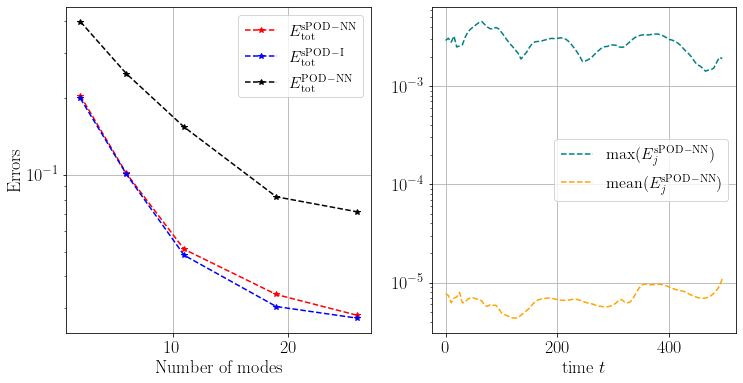

In [24]:
truncated_modes = np.array([2, 6, 11, 19, 26])
E_sPOD_NN = np.array([0.20450, 0.10123, 0.05103, 0.03390, 0.02811])
E_sPOD_I = np.array([0.19960, 0.10046, 0.04836, 0.03040, 0.02739])
E_POD_NN = np.array([0.39948, 0.24928, 0.15404, 0.08199, 0.07161])

err = errors[0]
err_max = [max(x) for x in err]
err_min = [min(x) for x in err]
err_mean = [mean(x) for x in err]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].semilogy(truncated_modes, E_sPOD_NN, color="red", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-NN}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_sPOD_I, color="blue", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-I}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_POD_NN, color="black", linestyle='--', marker="*", label=r"$E^{\mathrm{POD-NN}}_{\mathrm{tot}}$")
axs[0].set_xlabel('Number of modes')
axs[0].set_ylabel('Errors')
axs[0].grid()
axs[0].legend(loc='upper right')

axs[1].semilogy(df.t, err_max, color="teal", linestyle='--', label=r"max$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].semilogy(df.t, err_mean, color="orange", linestyle='--', label=r"mean$(E^{\mathrm{sPOD-NN}}_j)$")
# axs[1].semilogy(df.t, err_min, color="dimgrey", linestyle='--', label=r"min$(E(t, \mu))$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].legend(loc='center right')

save_fig(filepath=impath + 'Rel_err', figure=fig)
fig.savefig(impath + "Rel_err" + ".eps", format='eps',dpi=600, transparent=True)

In [25]:
# from matplotlib.ticker import MaxNLocator

# rank = 15
# U, SIG, VH = np.linalg.svd(np.squeeze(df.shifts_train[0][0, ...]), full_matrices=False)
# rel_err_list = [np.linalg.norm(np.squeeze(df.shifts_train[0][0, ...]) - U[:, :r+1].dot(np.diag(SIG[:r+1]).dot(VH[:r+1, :]))) / np.linalg.norm(np.squeeze(df.shifts_train[0][0, ...])) for r in range(rank)]
# fig, ax = plt.subplots(figsize=(7, 5))
# ax.semilogy(np.arange(rank) + 1, SIG[:rank] / SIG[0], color="brown", marker="o")
# # ax.semilogy(np.arange(rank), np.asarray(rel_err_list), color="brown", marker="o")
# ax.set_xlabel("Number of shift modes")
# ax.set_ylabel(r"$\sigma_{n^k_{\Delta}} / \sigma_{0^k_{\Delta}}$")
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.grid()
# save_fig(filepath=impath + 'shift_svd', figure=fig)
# fig.savefig(impath + "shift_svd" + ".eps", format='eps',dpi=600, transparent=True)